In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
from pprint import pprint
import re
import json
import gzip
class LTEParser:
    _mapa = {
        "B": "#Bearer",
        "T": "TimeStamp",
        "TX": "Transmission",
        "RX": "Receiver",
        "D": "Delay",
        "ID": "#Packet",
        "DST": "Destiny",
        "SRC": "Source",
        "SIZE": "Size"
    }
    @staticmethod
    def parse(inFile, flowDuration = 100):
        #VIDEO
        videoAverages = []
        videoFairness = []
        videoDelay = []
        videoJitter = []
        videoPLR = []
        #VOICE
        voiceAverages = []
        voiceFairness = []
        voiceDelay = []
        voiceJitter = []
        voicePLR = []
        #WEB
        WebAverages = []
        WebFairness = []
        WebDelay = []
        WebJitter = []
        WebPLR = []
        #CBR
        CBRAverages = []
        CBRFairness = []
        CBRDelay = []
        CBRJitter = []
        CBRPLR = []
        #GERAL
        packetLoss = []
        for sfile in inFile:
            content = ""
            print("Opening file: " + sfile)
            with gzip.open(sfile, 'rb') as file:
                content = file.read()
                content = content.decode('utf-8')
            print("Parsing file ...", end="")
            txContent, rxContent = LTEParser._parse(content)
            info = LTEParser.getFairnessIndex(rxContent, flowDuration)
            packetLossInfo = LTEParser.getPacketLossRatio(txContent, rxContent)
            delayInfo = LTEParser.getDelayJitter(rxContent)
            #VIDEO
            videoAverages.append(info['VIDEO']['Average'])
            videoFairness.append(info['VIDEO']['FairnessIndex'])
            videoDelay.append(delayInfo['VIDEO']['Average'])
            videoJitter.append(delayInfo['VIDEO']['StD'])
            videoPLR.append(packetLossInfo[1]['VIDEO'])
            #VOICE
            voiceAverages.append(info['VOIP']['Average'])
            voiceFairness.append(info['VOIP']['FairnessIndex'])
            voiceDelay.append(delayInfo['VOIP']['Average'])
            voiceJitter.append(delayInfo['VOIP']['StD'])
            voicePLR.append(packetLossInfo[1]['VOIP'])
            #WEBBUF
            WebAverages.append(info['WEB']['Average'])
            WebFairness.append(info['WEB']['FairnessIndex'])
            WebDelay.append(delayInfo['WEB']['Average'])
            WebJitter.append(delayInfo['WEB']['StD'])
            WebPLR.append(packetLossInfo[1]['WEB'])
            #CBRBUF
            CBRAverages.append(info['CBR']['Average'])
            CBRFairness.append(info['CBR']['FairnessIndex'])
            CBRDelay.append(delayInfo['CBR']['Average'])
            CBRJitter.append(delayInfo['CBR']['StD'])
            CBRPLR.append(packetLossInfo[1]['CBR'])
            #GERAL
            packetLoss.append(packetLossInfo[0])
        return [#VIDEO
                (sum(videoAverages)/len(videoAverages)),
                (sum(videoFairness)/len(videoFairness)),
                (sum(videoDelay)/len(videoDelay)),
                (sum(videoJitter)/len(videoJitter)),
                (sum(videoPLR)/len(videoPLR)),
                #VOICE
                (sum(voiceAverages)/len(voiceAverages)),
                (sum(voiceFairness)/len(voiceFairness)),
                (sum(voiceDelay)/len(voiceDelay)),
                (sum(voiceJitter)/len(voiceJitter)),
                (sum(voicePLR)/len(voicePLR)),
                #WEB
                (sum(WebAverages)/len(WebAverages)),
                (sum(WebFairness)/len(WebFairness)),
                (sum(WebDelay)/len(WebDelay)),
                (sum(WebJitter)/len(WebJitter)),
                (sum(WebPLR)/len(WebPLR)),
                #CBR
                (sum(CBRAverages)/len(CBRAverages)),
                (sum(CBRFairness)/len(CBRFairness)),
                (sum(CBRDelay)/len(CBRDelay)),
                (sum(CBRJitter)/len(CBRJitter)),
                (sum(CBRPLR)/len(CBRPLR)),
                #GERAL
                packetLoss]
    @staticmethod
    def _parse(content):
        txContent = LTEParser.parseTX(content)
        rxContent = LTEParser.parseRX(content)
        print("Done")
        return txContent, rxContent
    
    @staticmethod
    def parseTX(content):
        matches = re.findall(r"(^TX.+)", content, re.MULTILINE)
        if(matches == []):
            raise Exception("No matches in content for TX")
        dictPacketType = {"CBR": [], "VOIP": [], "VIDEO": [], "INF_BUF": [], "WEB": []}
        keys = dictPacketType.keys()
        for match in matches:
            values = match.split(' ')
            if values[1] in keys:
                tamanho = len(values)
                dic = {}
                for i in range(2, tamanho if tamanho%2==0 else tamanho-1, 2):
                    dic[LTEParser._mapa[values[i]]] = values[i+1]
                dic = dict(sorted(dic.items(), key=lambda x: x[0]))
                dictPacketType[values[1]].append(dic)
        return json.loads(json.dumps(dictPacketType))
        
    @staticmethod        
    def parseRX(content):
        matches = re.findall(r"(^RX.+)", content, re.MULTILINE)
        if(matches == []):
            raise Exception("No matches in content for RX")
        dictPacketType = {"CBR": [], "VOIP": [], "VIDEO": [], "INF_BUF": [], "WEB": []}
        keys = dictPacketType.keys()
        for match in matches:
            values = match.split(' ')
            if values[1] in keys:
                tamanho = len(values)
                dic = {}
                for i in range(2, tamanho if tamanho%2==0 else tamanho-1, 2):
                    dic[LTEParser._mapa[values[i]]] = values[i+1]
                dic = dict(sorted(dic.items(), key=lambda x: x[0]))
                dictPacketType[values[1]].append(dic)
        return json.loads(json.dumps(dictPacketType))
    
    @staticmethod
    def getPacketLossRatio(txContent, rxContent):
        dictPacketType = {"CBR": [], "VOIP": [], "VIDEO": [], "INF_BUF": [], "WEB": []}
        tx_pkts = 0
        rx_pkts = 0
        for key in txContent:
            keytx = len(txContent[key])
            tx_pkts += keytx
            keyrx = len(rxContent[key])
            rx_pkts += keyrx
            keyPLR = ((keytx - keyrx) / (keytx if keytx != 0 else 1)) * 100
            dictPacketType[key] = keyPLR
        plr = ((tx_pkts - rx_pkts) / tx_pkts) * 100
        return plr, dictPacketType
    
    @staticmethod
    def getDelayJitter(rxContent):
        delayPerApp = {}
        for app in rxContent:
            delayPerApp[app] = {"Sum": 0, "Average": 0, "StD": 0}
            delayPerApp[app]["Sum"] = sum(float(item["Delay"]) for item in rxContent[app])
            tamanho = len(rxContent[app])
            delayPerApp[app]["Average"] = (delayPerApp[app]["Sum"]/tamanho) if tamanho != 0 else 0
            delayPerApp[app]["StD"] = (sum((float(item["Delay"]) - delayPerApp[app]["Average"])**2 for item in rxContent[app])/ (tamanho - 1)) if tamanho-1 != 0 else 0
        return delayPerApp
    
    @staticmethod
    def getGoodput(rxContent, flowDuration):
        gputPerApp = {}
        for app in rxContent:
            gputPerApp[app] = {"Sum": 0, "Average": 0}
            gputPerApp[app]["Sum"] = sum(float(item["Size"])*8 for item in rxContent[app])
            gputPerApp[app]["Average"] = (gputPerApp[app]["Sum"])/flowDuration
        return gputPerApp
    
    @staticmethod
    def getThroughput(rxContent, flowDuration):
        tputPerApp = {}
        for app in rxContent:
            tputPerApp[app] = {"Sum": 0, "Average": 0}
            tputPerApp[app]["Sum"] = sum((float(item["Size"]) + 5)*8 for item in rxContent[app])
            tputPerApp[app]["Average"] = (tputPerApp[app]["Sum"])/flowDuration
        return tputPerApp
    
    @staticmethod
    def getSpectralEff():
        pass
    
    @staticmethod
    def getFairnessIndex(rxContent, flowDuration):
        fairnessPerApp = {}
        for app in rxContent:
            fairnessPerApp[app] = {"Sum": 0, "Average": 0, "SumSquared": 0, "SquaredSum": 0, "FairnessIndex": 0}
            if(len(rxContent[app]) > 0):
                fairnessPerApp[app]["Sum"] = sum(float(item["Size"])*8 for item in rxContent[app])
                fairnessPerApp[app]["Average"] = (fairnessPerApp[app]["Sum"])/flowDuration
                fairnessPerApp[app]["SumSquared"] = sum(pow(float(item["Size"])*8,2) for item in rxContent[app])
                fairnessPerApp[app]["SquaredSum"] = pow(fairnessPerApp[app]["Sum"], 2)
                division = (len(rxContent[app]) * fairnessPerApp[app]["SumSquared"])
                fairnessPerApp[app]["FairnessIndex"] = fairnessPerApp[app]["SquaredSum"] / division if division > 0 else 1
        return fairnessPerApp

In [9]:
base = "../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition"
ext = ".gz"
until = 21
users = 51
scheds = 9
files = {
         1: {
                3: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []},
                30: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []},
                120: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []}
            },
         2: {
                3: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []}, 
                30: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []},
                120: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []}
            },
         3: {
                3: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []},
                30: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []},
                120: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []}
            },
         4: {
                3: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []},
                30: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []},
                120: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []}},
         5: {
                3: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []},
                30: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []},
                120: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []}
             },
         6: {
                3: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []},
                30: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []},
                120: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []}
             },
         7: {
                3: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []},
                30: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []},
                120: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []}
             },
        8: {
                3: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []},
                30: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []},
                120: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []}
             }
        }
for sched in range(1,scheds):
    for ue in range(10, users, 10):
        for vel in [3]:
            for count in range(1,until):
                file = "/SCHED_" + str(sched) + "_UE_" + str(ue) + "_V_" + str(vel) +"_D_.1_" + str(count)
                filename = base + file + ext
                files[sched][vel][ue].append(filename)

In [10]:
metrics = {
    "VIDEO":{
        "GPUTS": {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[], 8: []},
        "FAIR": {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[], 8: []},
        "DELAY": {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[], 8: []},
        "JITTER": {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[], 8: []},
        "PLR": {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[], 8: []}
    },
    "VOICE":{
       "GPUTS": {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[], 8: []},
        "FAIR": {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[], 8: []},
        "DELAY": {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[], 8: []},
        "JITTER": {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[], 8: []},
        "PLR": {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[], 8: []}
    },
    "WEB":{
       "GPUTS": {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[], 8: []},
        "FAIR": {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[], 8: []},
        "DELAY": {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[], 8: []},
        "JITTER": {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[], 8: []},
        "PLR": {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[], 8: []}
    },
    "CBR":{
       "GPUTS": {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[], 8: []},
        "FAIR": {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[], 8: []},
        "DELAY": {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[], 8: []},
        "JITTER": {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[], 8: []},
        "PLR": {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[], 8: []}
    },
    "GERAL": {
      "PLR": {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[], 8: []}
    }
}
for sched in range(1, 9):
    for ue in range(10, users, 10):
        info = LTEParser.parse(files[sched][3][ue], 100)
        #VIDEO
        metrics["VIDEO"]["GPUTS"][sched].append(info[0])
        metrics["VIDEO"]["FAIR"][sched].append(info[1])
        metrics["VIDEO"]["DELAY"][sched].append(info[2])
        metrics["VIDEO"]["JITTER"][sched].append(info[3])
        metrics["VIDEO"]["PLR"][sched].append(info[4])
        #VOICE
        metrics["VOICE"]["GPUTS"][sched].append(info[5])
        metrics["VOICE"]["FAIR"][sched].append(info[6])
        metrics["VOICE"]["DELAY"][sched].append(info[7])
        metrics["VOICE"]["JITTER"][sched].append(info[8])
        metrics["VOICE"]["PLR"][sched].append(info[9])
        #WEB
        metrics["WEB"]["GPUTS"][sched].append(info[10])
        metrics["WEB"]["FAIR"][sched].append(info[11])
        metrics["WEB"]["DELAY"][sched].append(info[12])
        metrics["WEB"]["JITTER"][sched].append(info[13])
        metrics["WEB"]["PLR"][sched].append(info[14])
        #CBR
        metrics["CBR"]["GPUTS"][sched].append(info[15])
        metrics["CBR"]["FAIR"][sched].append(info[16])
        metrics["CBR"]["DELAY"][sched].append(info[17])
        metrics["CBR"]["JITTER"][sched].append(info[18])
        metrics["CBR"]["PLR"][sched].append(info[19])
        #GERAL
        metrics["GERAL"]["PLR"][sched].append(info[20])
    #VIDEO
for app in metrics:
    for metric in metrics[app]:
        for sched in metrics[app][metric]:
            metrics[app][metric][sched] = np.array(metrics[app][metric][sched], dtype=np.float32)

Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_1_UE_10_V_3_D_.1_1.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_1_UE_10_V_3_D_.1_2.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_1_UE_10_V_3_D_.1_3.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_1_UE_10_V_3_D_.1_4.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_1_UE_10_V_3_D_.1_5.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_1_UE_10_V_3_D_.1_6.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_1_UE_10_V_3_D_.1_7.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_1_UE_10_V_3_D_.1_8.gz
Parsing file ...Done


Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_1_UE_40_V_3_D_.1_7.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_1_UE_40_V_3_D_.1_8.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_1_UE_40_V_3_D_.1_9.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_1_UE_40_V_3_D_.1_10.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_1_UE_40_V_3_D_.1_11.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_1_UE_40_V_3_D_.1_12.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_1_UE_40_V_3_D_.1_13.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_1_UE_40_V_3_D_.1_1

Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_2_UE_20_V_3_D_.1_13.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_2_UE_20_V_3_D_.1_14.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_2_UE_20_V_3_D_.1_15.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_2_UE_20_V_3_D_.1_16.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_2_UE_20_V_3_D_.1_17.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_2_UE_20_V_3_D_.1_18.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_2_UE_20_V_3_D_.1_19.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_2_UE_20_V_3_D_.

Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_2_UE_50_V_3_D_.1_19.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_2_UE_50_V_3_D_.1_20.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_3_UE_10_V_3_D_.1_1.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_3_UE_10_V_3_D_.1_2.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_3_UE_10_V_3_D_.1_3.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_3_UE_10_V_3_D_.1_4.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_3_UE_10_V_3_D_.1_5.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_3_UE_10_V_3_D_.1_6.g

Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_3_UE_40_V_3_D_.1_5.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_3_UE_40_V_3_D_.1_6.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_3_UE_40_V_3_D_.1_7.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_3_UE_40_V_3_D_.1_8.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_3_UE_40_V_3_D_.1_9.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_3_UE_40_V_3_D_.1_10.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_3_UE_40_V_3_D_.1_11.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_3_UE_40_V_3_D_.1_12.

Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_4_UE_20_V_3_D_.1_11.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_4_UE_20_V_3_D_.1_12.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_4_UE_20_V_3_D_.1_13.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_4_UE_20_V_3_D_.1_14.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_4_UE_20_V_3_D_.1_15.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_4_UE_20_V_3_D_.1_16.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_4_UE_20_V_3_D_.1_17.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_4_UE_20_V_3_D_.

Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_4_UE_50_V_3_D_.1_17.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_4_UE_50_V_3_D_.1_18.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_4_UE_50_V_3_D_.1_19.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_4_UE_50_V_3_D_.1_20.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_5_UE_10_V_3_D_.1_1.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_5_UE_10_V_3_D_.1_2.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_5_UE_10_V_3_D_.1_3.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_5_UE_10_V_3_D_.1_4

Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_5_UE_40_V_3_D_.1_3.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_5_UE_40_V_3_D_.1_4.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_5_UE_40_V_3_D_.1_5.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_5_UE_40_V_3_D_.1_6.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_5_UE_40_V_3_D_.1_7.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_5_UE_40_V_3_D_.1_8.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_5_UE_40_V_3_D_.1_9.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_5_UE_40_V_3_D_.1_10.gz

Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_6_UE_20_V_3_D_.1_9.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_6_UE_20_V_3_D_.1_10.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_6_UE_20_V_3_D_.1_11.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_6_UE_20_V_3_D_.1_12.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_6_UE_20_V_3_D_.1_13.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_6_UE_20_V_3_D_.1_14.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_6_UE_20_V_3_D_.1_15.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_6_UE_20_V_3_D_.1

Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_6_UE_50_V_3_D_.1_15.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_6_UE_50_V_3_D_.1_16.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_6_UE_50_V_3_D_.1_17.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_6_UE_50_V_3_D_.1_18.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_6_UE_50_V_3_D_.1_19.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_6_UE_50_V_3_D_.1_20.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_7_UE_10_V_3_D_.1_1.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_7_UE_10_V_3_D_.1

Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_7_UE_40_V_3_D_.1_1.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_7_UE_40_V_3_D_.1_2.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_7_UE_40_V_3_D_.1_3.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_7_UE_40_V_3_D_.1_4.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_7_UE_40_V_3_D_.1_5.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_7_UE_40_V_3_D_.1_6.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_7_UE_40_V_3_D_.1_7.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_7_UE_40_V_3_D_.1_8.gz


Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_8_UE_20_V_3_D_.1_7.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_8_UE_20_V_3_D_.1_8.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_8_UE_20_V_3_D_.1_9.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_8_UE_20_V_3_D_.1_10.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_8_UE_20_V_3_D_.1_11.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_8_UE_20_V_3_D_.1_12.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_8_UE_20_V_3_D_.1_13.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_8_UE_20_V_3_D_.1_1

Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_8_UE_50_V_3_D_.1_13.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_8_UE_50_V_3_D_.1_14.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_8_UE_50_V_3_D_.1_15.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_8_UE_50_V_3_D_.1_16.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_8_UE_50_V_3_D_.1_17.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_8_UE_50_V_3_D_.1_18.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_8_UE_50_V_3_D_.1_19.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/P0_100WebApp_ConstantPosition/SCHED_8_UE_50_V_3_D_.

# WEB
## GPUT

In [23]:
MEGAWEB = {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: []}
for sched in metrics["WEB"]["GPUTS"]:
    MEGAWEB[sched] = np.true_divide(metrics["WEB"]["GPUTS"][sched], 1e+6)

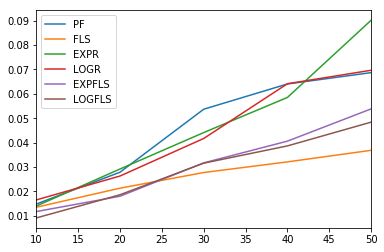

In [27]:
dfGPUTWEB = pd.DataFrame({'PF': MEGAWEB[1],
                       'FLS': MEGAWEB[4], 'EXPR': MEGAWEB[5], 'LOGR': MEGAWEB[6],
                        'EXPFLS': MEGAWEB[7], 'LOGFLS': MEGAWEB[8]},
                      index=[10,20,30,40,50])
plot = dfGPUTWEB.plot()
fig = plot.get_figure()
fig.savefig("./pdfs/GPUTWeb.pdf", bbox_inches='tight')

## Delay

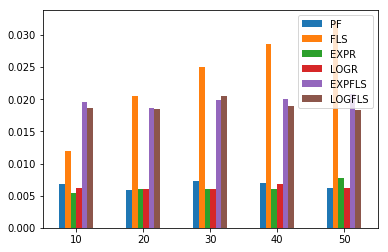

In [29]:
dfDELAYWEB = pd.DataFrame({'PF': metrics["WEB"]["DELAY"][1],
                            'FLS': metrics["WEB"]["DELAY"][4], 'EXPR': metrics["WEB"]["DELAY"][5], 'LOGR': metrics["WEB"]["DELAY"][6],
                             'EXPFLS': metrics["WEB"]["DELAY"][7], 'LOGFLS': metrics["WEB"]["DELAY"][8]},
                           index=[10,20,30,40,50])
plot = dfDELAYWEB.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/DelayWeb.pdf", bbox_inches='tight')

## Jitter

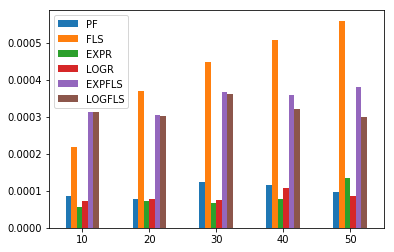

In [31]:
dfJITTERWEB = pd.DataFrame({'PF': metrics["WEB"]["JITTER"][1],
                            'FLS': metrics["WEB"]["JITTER"][4], 'EXPR': metrics["WEB"]["JITTER"][5], 'LOGR': metrics["WEB"]["JITTER"][6],
                            'EXPFLS': metrics["WEB"]["JITTER"][7], 'LOGFLS': metrics["WEB"]["JITTER"][8]},
                           index=[10,20,30,40,50])
plot = dfJITTERWEB.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/JitterWebPF.pdf", bbox_inches='tight')

## FAIRNESS

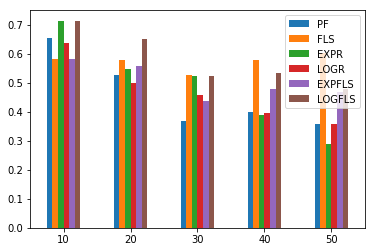

In [32]:
dfFAIRWEB = pd.DataFrame({'PF': metrics["WEB"]["FAIR"][1],
                            'FLS': metrics["WEB"]["FAIR"][4], 'EXPR': metrics["WEB"]["FAIR"][5], 'LOGR': metrics["WEB"]["FAIR"][6],
                            'EXPFLS': metrics["WEB"]["FAIR"][7], 'LOGFLS': metrics["WEB"]["FAIR"][8]},
                           index=[10,20,30,40,50])
plot = dfFAIRWEB.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/FairnessWeb.pdf", bbox_inches='tight')

## PLR

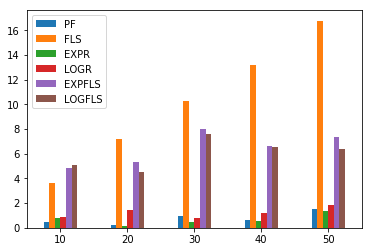

In [33]:
dfPLRWEB = pd.DataFrame({'PF': metrics["WEB"]["PLR"][1],
                            'FLS': metrics["WEB"]["PLR"][4], 'EXPR': metrics["WEB"]["PLR"][5], 'LOGR': metrics["WEB"]["PLR"][6],
                           'EXPFLS': metrics["WEB"]["PLR"][7], 'LOGFLS': metrics["WEB"]["PLR"][8]},
                           index=[10,20,30,40,50])
plot = dfPLRWEB.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/PacketLossWeb.pdf", bbox_inches='tight')

# CBR
## GPUT

In [34]:
MEGACBR = {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: []}
for sched in metrics["WEB"]["GPUTS"]:
    MEGACBR[sched] = np.true_divide(metrics["WEB"]["GPUTS"][sched], 1e+6)

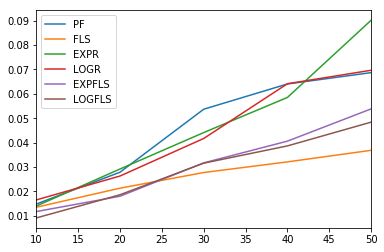

In [36]:
dfGPUTCBR = pd.DataFrame({'PF': MEGACBR[1],
                       'FLS': MEGACBR[4], 'EXPR': MEGACBR[5], 'LOGR': MEGACBR[6],
                        'EXPFLS': MEGACBR[7], 'LOGFLS': MEGACBR[8]},
                      index=[10,20,30,40,50])
plot = dfGPUTCBR.plot(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/GPUTCBR.pdf", bbox_inches='tight')

## Delay

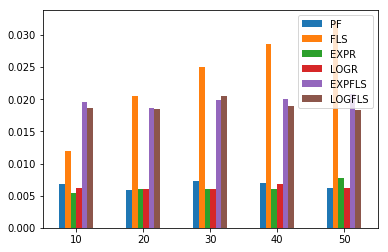

In [39]:
dfDELAYCBR = pd.DataFrame({'PF': metrics["WEB"]["DELAY"][1],
                            'FLS': metrics["WEB"]["DELAY"][4], 'EXPR': metrics["WEB"]["DELAY"][5], 'LOGR': metrics["WEB"]["DELAY"][6],
                             'EXPFLS': metrics["WEB"]["DELAY"][7], 'LOGFLS': metrics["WEB"]["DELAY"][8]},
                           index=[10,20,30,40,50])
plot = dfDELAYCBR.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/DelayCBR.pdf", bbox_inches='tight')

## Jitter

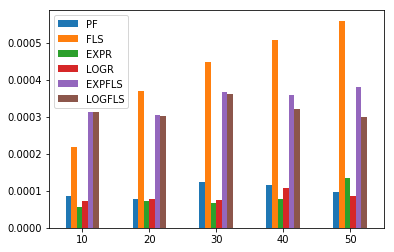

In [40]:
dfJITTERCBR = pd.DataFrame({'PF': metrics["WEB"]["JITTER"][1],
                            'FLS': metrics["WEB"]["JITTER"][4], 'EXPR': metrics["WEB"]["JITTER"][5], 'LOGR': metrics["WEB"]["JITTER"][6],
                            'EXPFLS': metrics["WEB"]["JITTER"][7], 'LOGFLS': metrics["WEB"]["JITTER"][8]},
                           index=[10,20,30,40,50])
plot = dfJITTERCBR.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/JitterCBRPF.pdf", bbox_inches='tight')

## FAIRNESS

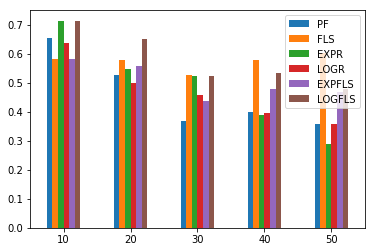

In [41]:
dfFAIRCBR = pd.DataFrame({'PF': metrics["WEB"]["FAIR"][1], 
                            'FLS': metrics["WEB"]["FAIR"][4], 'EXPR': metrics["WEB"]["FAIR"][5], 'LOGR': metrics["WEB"]["FAIR"][6],
                            'EXPFLS': metrics["WEB"]["FAIR"][7], 'LOGFLS': metrics["WEB"]["FAIR"][8]},
                           index=[10,20,30,40,50])
plot = dfFAIRCBR.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/FairnessCBR.pdf", bbox_inches='tight')

## PLR

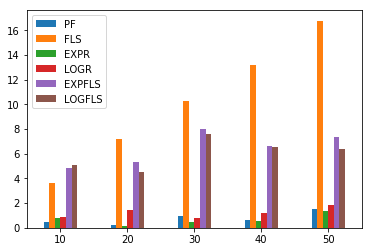

In [42]:
dfPLRCBR = pd.DataFrame({'PF': metrics["WEB"]["PLR"][1],
                            'FLS': metrics["WEB"]["PLR"][4], 'EXPR': metrics["WEB"]["PLR"][5], 'LOGR': metrics["WEB"]["PLR"][6],
                           'EXPFLS': metrics["WEB"]["PLR"][7], 'LOGFLS': metrics["WEB"]["PLR"][8]},
                           index=[10,20,30,40,50])
plot = dfPLRCBR.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/PacketLossCBR.pdf", bbox_inches='tight')

# Loss Ratio

In [45]:
averagePacketLoss = {}
for key in metrics["GERAL"]["PLR"]:
    averagePacketLoss[key] = []
    for i in range(0, 5):
        average = sum(metrics["GERAL"]["PLR"][key][i])/len(metrics["GERAL"]["PLR"][key][i])
        averagePacketLoss[key].append(average)

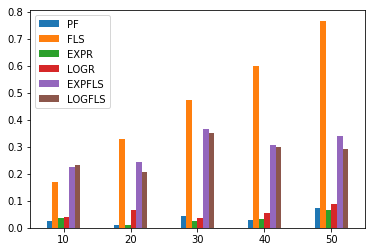

In [47]:
dfLossRatio = pd.DataFrame({'PF': averagePacketLoss[1],
                            'FLS': averagePacketLoss[4], 'EXPR': averagePacketLoss[5], 'LOGR': averagePacketLoss[6],
                           'EXPFLS': averagePacketLoss[7], 'LOGFLS': averagePacketLoss[8]},
                           index=[10,20,30,40,50])
plot = dfLossRatio.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/PacketLossRatio.pdf", bbox_inches='tight')